In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import pdb
import scipy.stats as stats
import scipy


In [2]:
data_dir = f'/lab_data/behrmannlab/claire/pepdoc/results_ex1' #read in the file; first value is the file name
bin_size = 5 #20 ms bins (EACH BIN IS 4 MS SO 5 ROWS ARE 20 MS)
# bin_size = 1 
categories = ['tool','nontool','bird','insect']
labels = np.asanyarray([0]*5 + [1]*5 + [2]*5 + [3]*5) #creates labels for data

#d_channels
dorsal_channels = [77, 78, 79, 80, 86, 87, 88, 89, 98, 99, 100, 110, 109, 118, 131, 143, 154, 163, 130, 142, 153, 162, 129, 141, 152, 128, 140, 127] # a list of channels
dorsal_columns  =[f'E{ii}' for ii in dorsal_channels] #convert channels into the same format as the columns

#v_channels
ventral_channels = [104, 105, 106, 111, 112, 113, 114, 115, 120, 121, 122, 123, 133, 134, 169, 177, 189, 159, 168, 176, 18, 199, 158, 167, 175, 187, 166, 174] # a list of channels
ventral_columns  =[f'E{ii}' for ii in ventral_channels] #convert channels into the same format as the columns

#c_channels
control_channels =  [11, 12, 18, 19, 20, 21, 25, 26, 27, 32, 33, 34, 37, 38]
control_columns  =[f'E{ii}' for ii in control_channels] #convert channels into the same format as the columns

svm_test_size = .4
svm_splits = 20
sss = StratifiedShuffleSplit(n_splits=svm_splits, test_size=svm_test_size)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))

In [3]:
'''
Load All Subjects Data
'''
all_subs = ['AC_newepoch','AM', 'BB','CM','CR','GG','HA','IB','JM','JR','KK','KT','MC','MH','NF','SB','SG','SOG','TL','ZZ']
all_sub_data = []
all_sub_dorsal =[]
all_sub_ventral =[]
all_sub_control = []

for nSubject in all_subs: #loop through subs
    all_data =[]
    all_ventral =[]
    all_dorsal =[]
    all_control = []
    for category in categories: #loop through categories
        for nn in range(1,6): #loop through exemplars in categories
           
            curr_df = pd.read_csv(f'/{data_dir}/{nSubject}/{category}s/{category}{nn}.tsv' , sep='\t')#read in the file; first value is the file name
            curr_df = curr_df.T #use pandas to transpose data
            curr_df.columns = curr_df.iloc[0] #set the column names to the first row
            curr_df = curr_df.drop(curr_df.index[0]) #drop the first row
            curr_df = curr_df.astype(float) #convert to float

            bin_data = curr_df.rolling(bin_size).mean() #rolling avg given the bin size
            
            bin_data = bin_data.dropna() #drop missing values
            bin_data = bin_data.reset_index() #reset the index of the dataframe
            
            all_channel_data = bin_data.drop(columns = ['index']) #drop columns that are not channels

            dorsal_df = pd.DataFrame() #create empty data frame that you will populate with only those channels you care about
            for ii in dorsal_columns: #loop through all channels of interest
                if ii in all_channel_data.columns: #check if current channel exists in df
                    dorsal_df[ii] = all_channel_data[ii] #if it does add it the empty one

            ventral_df = pd.DataFrame() #create empty data frame that you will populate with only those channels you care about
            for ii in ventral_columns: #loop through all channels of interest
                if ii in all_channel_data.columns: #check if current channel exists in df
                    ventral_df[ii] = all_channel_data[ii] #if it does add it the empty one


            control_df = pd.DataFrame() #create empty data frame that you will populate with only those channels you care about
            for ii in control_columns: #loop through all channels of interest
                if ii in all_channel_data.columns: #check if current channel exists in df
                    control_df[ii] = all_channel_data[ii] #if it does add it the empty one

            all_data.append(all_channel_data.to_numpy())
            all_dorsal.append(dorsal_df.to_numpy())
            all_ventral.append(ventral_df.to_numpy())
            all_control.append(control_df.to_numpy())
            #all_subs.append(nSubject.split('_')[0])
            
          
    all_data = np.asanyarray(all_data) # the error "ValueError: could not broadcast input array from shape (138,240) into shape (138,)" is because the data is not the same length for all participants/error in adding participants.
    all_dorsal = np.asanyarray(all_dorsal)
    all_ventral = np.asanyarray(all_ventral)  
    all_control = np.asanyarray(all_control)

    all_sub_data.append(all_data) #add the subject to the list of subjects
    all_sub_dorsal.append(all_dorsal)
    all_sub_ventral.append(all_ventral)
    all_sub_control.append(all_control)

In [9]:
'''
Decode from all dorsal channels
'''

d_sub_decode = []

for dorsal_sub_decode in all_sub_dorsal: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    dorsal_cat_decode = []
    for time in range(0, dorsal_sub_decode.shape[1]):
        X = dorsal_sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index] 
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        dorsal_cat_decode.append(np.mean(temp_acc))

    dorsal_cat_decode = np.asanyarray(dorsal_cat_decode)
    d_sub_decode.append(dorsal_cat_decode)

In [10]:
'''
Decode from all ventral channels
'''

v_sub_decode = []

for ventral_sub_decode in all_sub_ventral: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    ventral_cat_decode = []
    for time in range(0, ventral_sub_decode.shape[1]):
        X = ventral_sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        ventral_cat_decode.append(np.mean(temp_acc))

    ventral_cat_decode = np.asanyarray(ventral_cat_decode)
    v_sub_decode.append(ventral_cat_decode)

In [6]:
'''
Decode from all control channels
'''

c_sub_decode = []

for control_sub_decode in all_sub_control: # for loop print each iteration of the list (each column)
    #empty list to hold acc
    control_cat_decode = []
    for time in range(0, control_sub_decode.shape[1]):
        X = control_sub_decode[:,time,:] #grab all data for that time point
        y = labels #set Y to be the labels
        
        temp_acc = [] #create empty list accuracy for each timepoint
        for train_index, test_index in sss.split(X, y): #grab indices for training and test

            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = y[train_index], y[test_index]

            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
            clf.fit(X_train, y_train)   

            temp_acc.append(clf.score(X_test, y_test))

        control_cat_decode.append(np.mean(temp_acc))

    control_cat_decode = np.asanyarray(control_cat_decode)
    c_sub_decode.append(control_cat_decode)

In [11]:
'''Time Comparison'''
#dorsal
d_sub_decode = np.asanyarray(d_sub_decode)
d_timecomp = []
for i in range(0, d_sub_decode.shape[1]):
    a = stats.ttest_1samp((d_sub_decode[:,i]), .25, axis = 0, alternative='greater')
    d_timecomp.append(a)


#ventral
v_sub_decode = np.asanyarray(v_sub_decode)
timecomp_v = []
for i in range(0, v_sub_decode.shape[1]):
    a = stats.ttest_1samp((v_sub_decode[:,i]), .25, axis = 0, alternative='greater')
    timecomp_v.append(a)


#control
c_sub_decode = np.asanyarray(c_sub_decode)
timecomp_c = []
for i in range(0, c_sub_decode.shape[1]):
    a = stats.ttest_1samp((c_sub_decode[:,i]), .25, axis = 0, alternative='greater')
    timecomp_c.append(a)



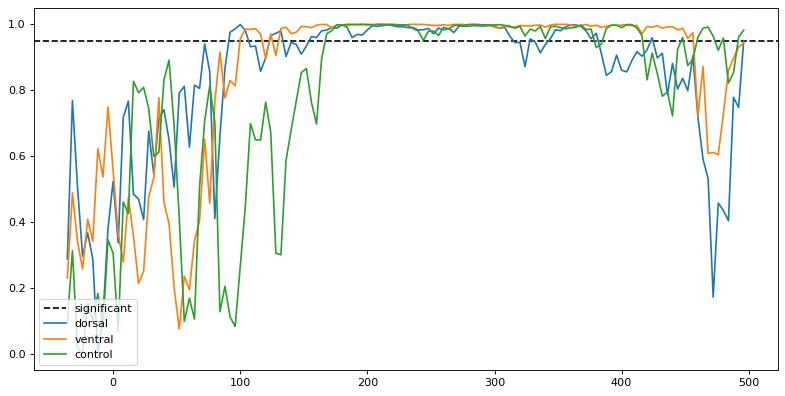

In [12]:
from matplotlib.pyplot import figure

timepoints = list(range(-36, 500, 4))
fig = figure(num=None, figsize=(12, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axhline(.95, color = 'k', label='significant', linestyle='--')

d_timecomp = np.asanyarray(d_timecomp)
plt.plot(timepoints, 1-(d_timecomp[:,1]), label = 'dorsal')

v_timecomp = np.asanyarray(timecomp_v)
plt.plot(timepoints, 1-(v_timecomp[:,1]), label = 'ventral')

c_timecomp = np.asanyarray(timecomp_c)
plt.plot(timepoints, 1-(c_timecomp[:,1]), label = 'control')

plt.legend(loc='lower left')

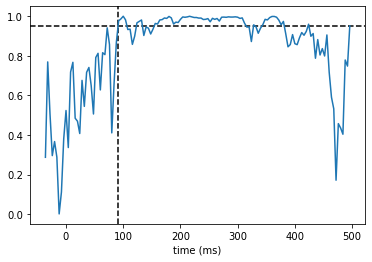

In [18]:
timepoints = list(range(-36, 500, 4))
plt.xlabel('time (ms)')
plt.axhline(.95, color = 'k', label='significant', linestyle='--')
plt.axvline(90, color = 'k', label='significant', linestyle='--')

d_timecomp = np.asanyarray(d_timecomp)
plt.plot(timepoints, 1-(d_timecomp[:,1]))

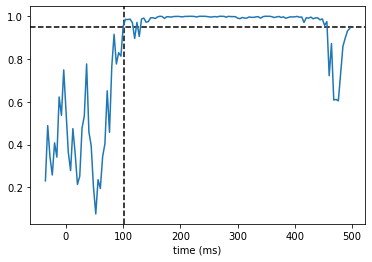

In [17]:
timepoints = list(range(-36, 500, 4))
plt.xlabel('time (ms)')
plt.axhline(.95, color = 'k', label='significant', linestyle='--')
plt.axvline(101, color = 'k', label='significant', linestyle='--')

v_timecomp = np.asanyarray(timecomp_v)
plt.plot(timepoints, 1-(v_timecomp[:,1]))

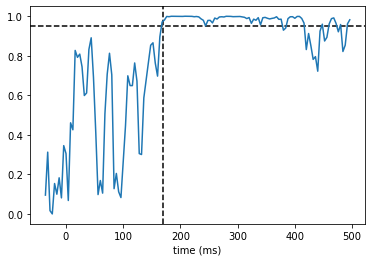

In [16]:
timepoints = list(range(-36, 500, 4))
plt.xlabel('time (ms)')
plt.axhline(.95, color = 'k', label='significant', linestyle='--')
plt.axvline(170, color = 'k', label='significant', linestyle='--')

c_timecomp = np.asanyarray(timecomp_c)
plt.plot(timepoints, 1-(c_timecomp[:,1]))

In [70]:
#RESAMPLING

#how many times to do the resampling
#we'll eventually set this to somethign really high like 10,000
iter = 100

d_sub_decode = d_sub_decode[:, 9:]
v_sub_decode = v_sub_decode[:, 9:]
c_sub_decode = c_sub_decode[:, 9:]

#convert data to pandas dataframe
#this is just because pandas has a good resampling function 
d_sub_decode = pd.DataFrame(d_sub_decode)
v_sub_decode = pd.DataFrame(v_sub_decode)
c_sub_decode = pd.DataFrame(c_sub_decode)

#Create empty lists that will hold the results of each resample
d_boot = []
v_boot = []
c_boot = []

for ii in range(0,iter):
    
    #resample the sub decode data with replacement
    d_sub_sample = d_sub_decode.sample(d_sub_decode.shape[0],replace = True, random_state=ii)
    v_sub_sample = v_sub_decode.sample(v_sub_decode.shape[0],replace = True, random_state=ii)
    c_sub_sample = c_sub_decode.sample(c_sub_decode.shape[0],replace = True, random_state=ii)
    
    #convert it back to a numpy array
    d_sub_sample = d_sub_sample.to_numpy() 
    v_sub_sample = v_sub_sample.to_numpy()
    c_sub_sample = c_sub_sample.to_numpy()

    #calculate the bootstrap sample mean
    d_timecomp = []
    v_timecomp = []
    c_timecomp = []

    for time in range(0,d_sub_sample.shape[1]):
        d_stat= stats.ttest_1samp(d_sub_sample[:,time], .25, axis = 0, alternative='greater')
        v_stat = stats.ttest_1samp(v_sub_sample[:,time], .25, axis = 0, alternative='greater')
        c_stat = stats.ttest_1samp(c_sub_sample[:,time], .25, axis = 0, alternative='greater')

        #append the p-value for every time point
        d_timecomp.append(d_stat[1])  
        v_timecomp.append(v_stat[1])
        c_timecomp.append(c_stat[1])
    
    #reconvert p-value list into a numpy array
    d_timecomp = np.asanyarray(d_timecomp)
    v_timecomp = np.asanyarray(v_timecomp)
    c_timecomp = np.asanyarray(c_timecomp)
    
    #find the the first time point that is below change (0.05)
    #np.where simply returns the indices (i.e., spots in an array), that meet some condition
    #i'm simply grabbing the first value of that list, which corresponds to the first time point above chance
    d_onset = np.where(d_timecomp <.05,)[0][0]
    v_onset = np.where(v_timecomp <.05,)[0][0]
    c_onset = np.where(c_timecomp <.05,)[0][0]
    
    #convert to the actual time point
    d_onset = d_onset *4
    v_onset = v_onset *4
    c_onset = c_onset *4
    
    #add the onset value from the resample to a list
    d_boot.append(d_onset)
    v_boot.append(v_onset)
    c_boot.append(c_onset)

NameError: name 'd_boot' is not defined

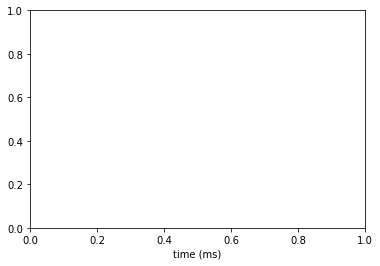

In [19]:
plt.xlabel('time (ms)')
timepooints = list(range(-36, 500, 4))
plt.plot(timepoints, d_boot, label = 'dorsal')
plt.show()

plt.hist(d_boot, range = [0, 150], label='dorsal', color='b', alpha=.5, bins= 30, density=True)
plt.hist(v_boot,range = [0, 150], label='ventral', color='orange', alpha=.5, bins= 30, density=True)

plt.legend(loc='upper right')

In [83]:
d_boot = np.asanyarray(d_boot)
v_boot = np.asanyarray(v_boot)

diff = d_boot - v_boot

In [84]:
print(np.mean(diff))
print(np.std(diff)/np.sqrt(iter))

-27.72
3.088173570251517


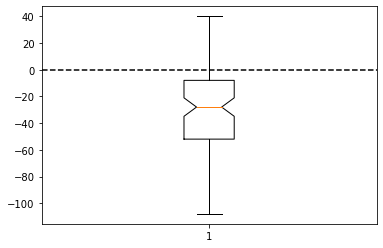

In [88]:
plt.boxplot(diff,notch=True)
plt.axhline(0, color = 'k', label='significant', linestyle='--')

In [89]:
#plot the difference values with confidence intervals
alpha = .025
ci_low = np.percentile(diff, alpha*100)
ci_high= np.percentile(diff, 100-alpha*100)

In [ ]:
print(ci_low)
print(ci_high)

In [26]:
#filepath = '/user_data/csimmon2/git_repos/pepdoc/analysis/d_sub_decode.npy')

np.save('d_sub_decode.npy', d_sub_decode)
#d_sub_decode = np.load(d_sub_decode)
np.save('v_sub_decode.npy', v_sub_decode)
#v_sub_decode = np.load(v_sub_decode)
np.save('c_sub_decode.npy', c_sub_decode)
#c_sub_decode = np.load(c_sub_decode)
